In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/amazon-walmart-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','amazon-walmart-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in data.keys():
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/amazon-walmart-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/amazon-walmart-reduced/glove-300.matrix.npy',
                        text_columns = ['brand', 'groupname', 'title', 'shelfdescr',
                                        'shortdescr', 'longdescr'],
                        numeric_columns = ['price', 'shipweight', 'length',
                                           'width', 'height'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio',
                                             'unscaled_inverse_lp',
                                             'scaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False,
                        embedding_trainable=True)

Number of inputs to dense layer: 21


# Train model 

In [141]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=2048,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 93243 samples, validate on 11656 samples
Epoch 1/1
93243/93243 [==============================] - 14s 145us/step - loss: 8.9419e-04 - acc: 0.9998 - val_loss: 0.0078 - val_acc: 0.9986


# Learning curves

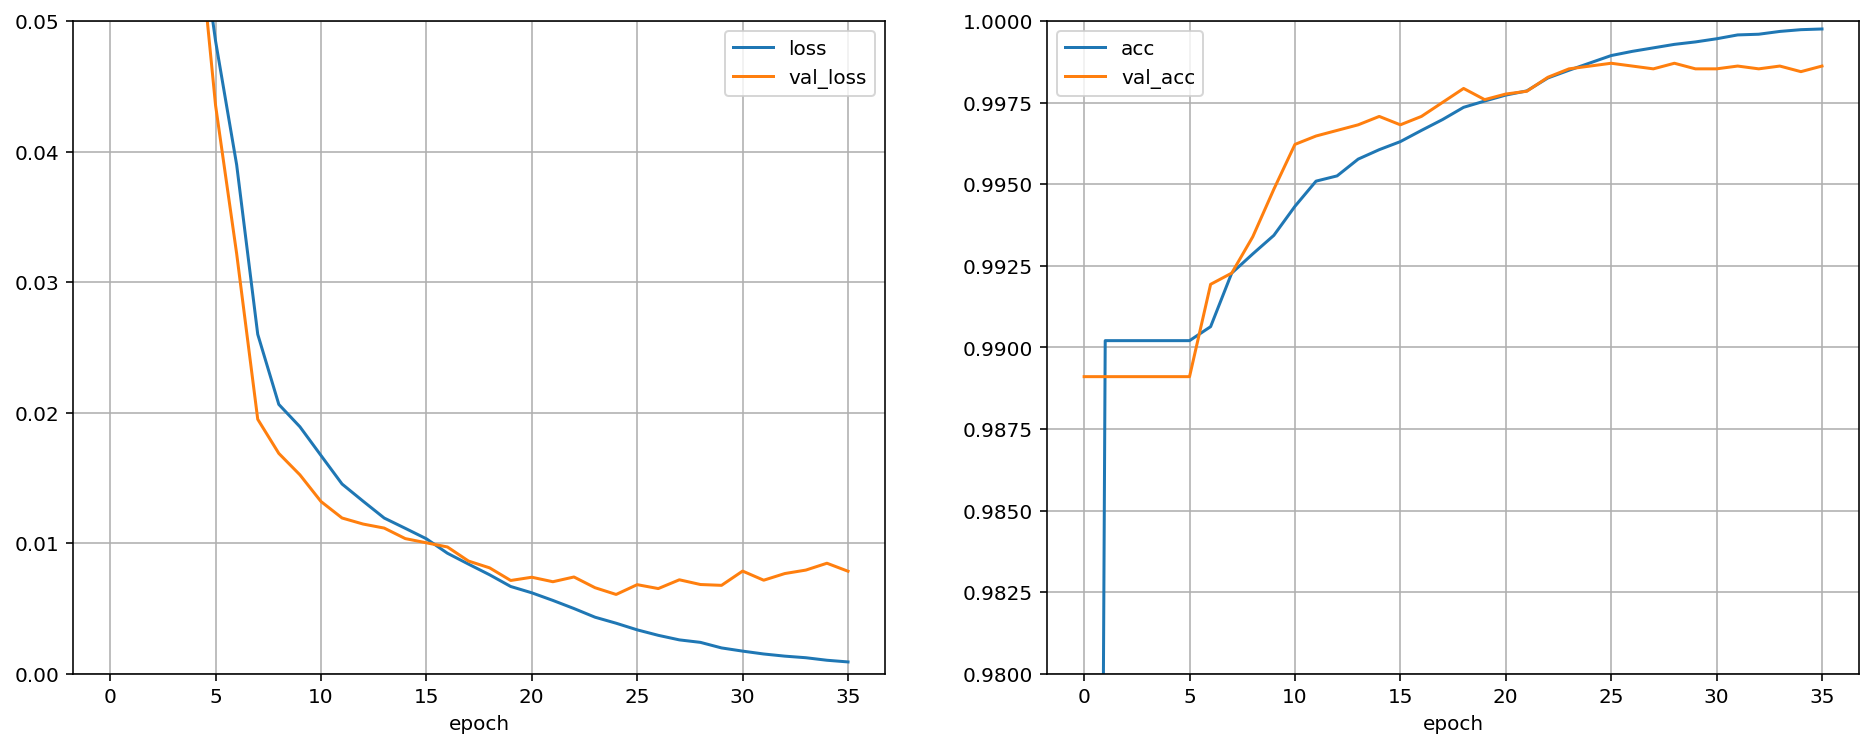

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.05)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(0.98, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [133]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11529
          1       0.95      0.91      0.93       127

avg / total       1.00      1.00      1.00     11656

[[11523     6]
 [   11   116]]


In [134]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['brand', 'groupname', 'title', 'shelfdescr',
           'shortdescr', 'longdescr']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,brand,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,...,groupname,title,price,shelfdescr,shortdescr,longdescr,shipweight,length,width,height
9125,8092,tomtom,vehicle gps,tomtom via 1505t portable gps navigator with lifetime traffic,179.95,get over million more miles of mapped roads in the us outsmart delays with free lifetime traffic updates without advertising navigate with ease using premium maps of the us canada amp mexico travel in style with the new slim design and integrated fold and go easyport mount plan routes easily with smarter user interface on bright touchscreen,tomtom via 1505t portable gps navigator with lifetime traffic,the via story hit the road and the new tomtom via series holds the latest navigation technology in fresh sleek design including an integrated fold amp go easyport travel confidently with superior routing and the most accurate dependable maps in the gps in fact tomtom gives you one million more miles of mapped roads in the us the via range offers large array of unique lifetime traffic and map updates bluetooth calling and natural voice recognition with destination address at affordable the tomtom via 1505t introducing the tomtom via 1505t equipped with superior driving travel with ease and style throughout the us canada amp this innovative navigator boasts design classic finish new intuitive user interface and using tomtom maps you have access to one million more miles of mapped road in the us than you would using any other gps brand and with tomtom map share updates you can easily make instant changes and download verified updates from other tomtom users to y...,0.0,5.3,...,gps,tomtoim via 1505t,179.95,lcd widescreen 480 272 pixels spoken street names advanced lane guidance,the tomtom via 1505t portable gps boasts bright this innovative navigator also has super slim design classic finish and new intuitive user interface that will assist your travel throughout the us canada and mexico with ease and,tomtom via 1505t lcd widescreen 480 272 pixels presents information clearly and brightly for optimal navigation spoken street names announces directions includes us canada and mexico using tomtom premium maps on demand updates with the latest maps advanced lane guidance never miss your exit includes adhesive disk usb cable usb traffic receiver and home charging cable get started right out of the box battery lasts up to hours,1.10,7.000,6.90,1.900
7803,16033,svat,electronics,svat digital wireless dvr security system with sd card recording long range night visi,438.72,wireless system allows for easy gb secure digital card records up to 350 minutes of continuos wireless camera has 18 infrared leds to allow up to night vision protective aluminum housing allows system to be used year round indoors amp expandable up to,nan,wireless system allows for easy setup2 gb secure digital card records up to 350 minutes of continuos footagewireless camera has 18 infrared leds to allow up to night vision rangeprotective aluminum housing allows system to be used year round indoors amp outdoorsexpandable up to camerasadvanced settings24 hour recording amp remote control access to adjust settings amp recording schedules24 lifetime live customer supportreceiverupc 871363012081shipping dimensions shipping weight,0.0,0.0,...,garden general,svat digital wireless dvr security system with receiver sd card recording and long range night vision cameras,249.82,record up to 350 min of video and audio on included 2gb sd card advanced motion detection settings includes remote control,svat digital wireless dvr security system can be used to monitor and record video and audio in any indoor or outdoor space at any time of the this wireless plug and play system allows for easy set up in matter of minutes and the included 2gb sd card can record up to 350 minutes of continuous audio and video the wireless weather resistant camera included with this system has 18 infrared leds that allow you to see up to 40 awa

# Save model and histories 

In [135]:
pd.DataFrame(histories).to_csv('../data/histories/amazon-walmart-base-1t-num.csv', index=False)
model.save_weights('../data/models/amazon-walmart-base-1t-num')

# Test model 

In [4]:
model.load_weights('../data/models/amazon-walmart-base-1t-num')
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99879   0.99948   0.99913     11541
          1    0.94340   0.87719   0.90909       114

avg / total    0.99825   0.99828   0.99825     11655

[[11535     6]
 [   14   100]]
